# Task 3: Statistical Validation of Risk Drivers (Hypothesis Testing)

This notebook performs comprehensive statistical hypothesis testing to validate or reject key hypotheses about risk drivers for car insurance customers. The analysis identifies statistically significant differences in risk across provinces, zip codes, and gender, and translates findings into actionable business recommendations.

## Objectives

1. **Select Metrics (KPIs)**: Choose and justify KPIs to measure risk
2. **Data Segmentation**: Create A/B testing groups
3. **Statistical Testing**: Perform appropriate statistical tests
4. **Analysis & Reporting**: Present results with visualizations
5. **Business Recommendations**: Translate statistical results into actionable insights


In [12]:
import os
import sys
from pathlib import Path
import logging
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

# Add src to path for imports
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

# Import our modules
from src.data_loader import load_insurance_data, get_data_path
from src.data_cleaner import clean_insurance_data
from src.statistical_tests import (
    calculate_claim_frequency,
    calculate_claim_severity,
    create_ab_groups,
    test_proportion_difference,
    test_chi_squared,
    test_mean_difference,
    test_anova,
    calculate_margin_metrics
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create reports directory if it doesn't exist
reports_dir = PROJECT_ROOT / "reports"
reports_dir.mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"Reports directory: {reports_dir}")


Libraries imported successfully!
Reports directory: C:\Users\HomePC\Desktop\Fourth\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\reports


## 1. Data Loading and Preparation


In [13]:
# Load and clean data
DATA_PATH = get_data_path()
df = load_insurance_data(filepath=DATA_PATH, low_memory=False)

# Clean data
df = clean_insurance_data(
    df,
    numeric_columns=["TotalPremium", "TotalClaims", "SumInsured", "CustomValueEstimate"],
    calculate_loss_ratio_flag=True,
    create_month_flag=True
)

# Create binary claim indicator
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"\nKey columns: {', '.join(['TotalPremium', 'TotalClaims', 'HasClaim', 'Margin', 'Province', 'PostalCode', 'Gender'])}")
print(f"\nData preview:")
df[['PolicyID', 'Province', 'PostalCode', 'Gender', 'TotalPremium', 'TotalClaims', 'HasClaim', 'Margin']].head()


2025-12-06 20:54:23,806 - src.data_loader - INFO - Loading data from: C:\Users\HomePC\Desktop\Fourth\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\data\MachineLearningRating_v3.txt
2025-12-06 20:55:26,982 - src.data_loader - INFO - Successfully loaded 1000098 rows and 52 columns
2025-12-06 20:55:32,135 - src.data_cleaner - INFO - Converted column 'TotalPremium' to numeric
2025-12-06 20:55:32,155 - src.data_cleaner - INFO - Converted column 'TotalClaims' to numeric
2025-12-06 20:55:32,184 - src.data_cleaner - INFO - Converted column 'SumInsured' to numeric
2025-12-06 20:55:32,204 - src.data_cleaner - INFO - Converted column 'CustomValueEstimate' to numeric
2025-12-06 20:55:36,201 - src.data_cleaner - INFO - Converted column 'TotalClaims' to numeric
2025-12-06 20:55:36,219 - src.data_cleaner - INFO - Converted column 'TotalPremium' to numeric
2025-12-06 20:55:36,935 - src.data_cleaner - INFO - Calculated loss ratio in column 'LossRatio'
2025-12-06 20:55:39,981 - src.data_cleane

Data loaded: 1,000,098 rows, 56 columns

Key columns: TotalPremium, TotalClaims, HasClaim, Margin, Province, PostalCode, Gender

Data preview:


,PolicyID,Province,PostalCode,Gender,TotalPremium,TotalClaims,HasClaim,Margin
0,12827,Gauteng,1459,Not specified,21.929825,0.0,0,21.929825
1,12827,Gauteng,1459,Not specified,21.929825,0.0,0,21.929825
2,12827,Gauteng,1459,Not specified,0.000000,0.0,0,0.000000
3,12827,Gauteng,1459,Not specified,512.848070,0.0,0,512.848070
4,12827,Gauteng,1459,Not specified,0.000000,0.0,0,0.000000


## 2. Metric Selection (KPIs)

We will use the following KPIs to measure insurance risk:

1. **Claim Frequency**: Proportion of policies with ≥1 claim
2. **Claim Severity**: Average claim amount among claimants
3. **Loss Ratio**: TotalClaims / TotalPremium
4. **Margin**: TotalPremium − TotalClaims

### Justification:
- **Claim Frequency**: Captures how often claims occur (frequency risk)
- **Claim Severity**: Captures the magnitude of claims when they occur (severity risk)
- **Loss Ratio**: Industry-standard metric combining frequency and severity
- **Margin**: Direct measure of profitability


In [14]:
# Calculate portfolio-level KPIs
total_policies = len(df)
total_with_claims = df['HasClaim'].sum()
claim_frequency_portfolio = total_with_claims / total_policies

total_premium = df['TotalPremium'].sum()
total_claims = df['TotalClaims'].sum()
loss_ratio_portfolio = total_claims / total_premium if total_premium > 0 else 0
margin_portfolio = total_premium - total_claims

# Claim severity (only for claimants)
claimants = df[df['TotalClaims'] > 0]
claim_severity_portfolio = claimants['TotalClaims'].mean() if len(claimants) > 0 else 0

print("Portfolio-Level KPIs:")
print(f"  Total Policies: {total_policies:,}")
print(f"  Claim Frequency: {claim_frequency_portfolio:.4f} ({claim_frequency_portfolio*100:.2f}%)")
print(f"  Claim Severity: R{claim_severity_portfolio:,.2f}")
print(f"  Loss Ratio: {loss_ratio_portfolio:.4f} ({loss_ratio_portfolio*100:.2f}%)")
print(f"  Total Margin: R{margin_portfolio:,.2f}")
print(f"  Margin Ratio: {(margin_portfolio/total_premium)*100:.2f}%")


Portfolio-Level KPIs:
  Total Policies: 1,000,098
  Claim Frequency: 0.0028 (0.28%)
  Claim Severity: R23,273.39
  Loss Ratio: 1.0477 (104.77%)
  Total Margin: R-2,955,983.47
  Margin Ratio: -4.77%


## 3. Hypothesis Testing

### Hypotheses to Test:

1. **H₀**: There are no risk differences across provinces
2. **H₀**: There are no risk differences between zip codes
3. **H₀**: There is no significant margin (profit) difference between zip codes
4. **H₀**: There is no significant risk difference between women and men


### Hypothesis 1: Risk Differences Across Provinces


In [15]:
# Analyze provinces
province_summary = calculate_claim_frequency(df, 'Province')
province_summary = province_summary.sort_values('TotalPolicies', ascending=False)

print("Province Summary (Top 10 by Policy Count):")
print(province_summary.head(10).to_string(index=False))

# Select two provinces for A/B testing (top 2 by policy count)
top_provinces = province_summary.head(2)['Province'].values
province_a = top_provinces[0]
province_b = top_provinces[1]

print(f"\nSelected for A/B Testing:")
print(f"  Group A (Control): {province_a}")
print(f"  Group B (Test): {province_b}")


Province Summary (Top 10 by Policy Count):
     Province  NumClaims  TotalPolicies  ClaimFrequency  TotalClaims  AvgClaimAmount  TotalPremium  AvgPremium  LossRatio        Margin  MarginPerPolicy
      Gauteng       1322         393865          0.0034 2.939415e+07         74.6300  2.405377e+07     61.0711   1.222018 -5.340374e+06       -13.558894
 Western Cape        370         170796          0.0022 1.038977e+07         60.8315  9.806559e+06     57.4168   1.059472 -5.832152e+05        -3.414689
KwaZulu-Natal        483         169781          0.0028 1.430138e+07         84.2343  1.320908e+07     77.8007   1.082693 -1.092303e+06        -6.433598
   North West        349         143287          0.0024 5.920250e+06         41.3174  7.490508e+06     52.2763   0.790367  1.570258e+06        10.958832
   Mpumalanga        128          52718          0.0024 2.044675e+06         38.7851  2.836292e+06     53.8012   0.720897  7.916166e+05        15.016059
 Eastern Cape         50          30336

In [16]:
# Create A/B groups for provinces
group_a_prov, group_b_prov = create_ab_groups(
    df, 
    'Province', 
    province_a, 
    province_b,
    balance_features=['Gender', 'VehicleType']  # Balance on other features
)

# Summary statistics
print(f"\nGroup A ({province_a}):")
print(f"  Policies: {len(group_a_prov):,}")
print(f"  Claim Frequency: {group_a_prov['HasClaim'].mean():.4f}")
print(f"  Avg Premium: R{group_a_prov['TotalPremium'].mean():.2f}")
print(f"  Avg Claims: R{group_a_prov['TotalClaims'].mean():.2f}")
print(f"  Loss Ratio: {(group_a_prov['TotalClaims'].sum() / group_a_prov['TotalPremium'].sum()):.4f}")

print(f"\nGroup B ({province_b}):")
print(f"  Policies: {len(group_b_prov):,}")
print(f"  Claim Frequency: {group_b_prov['HasClaim'].mean():.4f}")
print(f"  Avg Premium: R{group_b_prov['TotalPremium'].mean():.2f}")
print(f"  Avg Claims: R{group_b_prov['TotalClaims'].mean():.2f}")
print(f"  Loss Ratio: {(group_b_prov['TotalClaims'].sum() / group_b_prov['TotalPremium'].sum()):.4f}")


2025-12-06 20:56:20,347 - src.statistical_tests - INFO - Group A (Gauteng): 393865 records
2025-12-06 20:56:20,351 - src.statistical_tests - INFO - Group B (Western Cape): 170796 records
2025-12-06 20:56:21,236 - src.statistical_tests - INFO - Balanced groups to 170796 records each



Group A (Gauteng):
  Policies: 170,796
  Claim Frequency: 0.0034
  Avg Premium: R60.94
  Avg Claims: R74.88
  Loss Ratio: 1.2288

Group B (Western Cape):
  Policies: 170,796
  Claim Frequency: 0.0022
  Avg Premium: R57.42
  Avg Claims: R60.83
  Loss Ratio: 1.0595


In [17]:
# Statistical Test 1: Chi-Squared Test for Claim Frequency
chi2_results_prov = test_chi_squared(group_a_prov, group_b_prov)

print("Chi-Squared Test Results:")
print(f"  Test: {chi2_results_prov['test_name']}")
print(f"  Chi² statistic: {chi2_results_prov['chi2_statistic']:.4f}")
print(f"  p-value: {chi2_results_prov['p_value']:.6f}")
print(f"  Degrees of freedom: {chi2_results_prov['degrees_of_freedom']}")
print(f"  Decision: {chi2_results_prov['interpretation']}")
print(f"\nContingency Table:")
print(chi2_results_prov['contingency_table'])

# Statistical Test 2: Z-Test for Proportions
ztest_results_prov = test_proportion_difference(group_a_prov, group_b_prov)

print(f"\nTwo-Proportion Z-Test Results:")
print(f"  Test: {ztest_results_prov['test_name']}")
print(f"  Group A proportion: {ztest_results_prov['group_a_proportion']:.4f}")
print(f"  Group B proportion: {ztest_results_prov['group_b_proportion']:.4f}")
print(f"  Difference: {ztest_results_prov['difference']:.4f}")
print(f"  Z-statistic: {ztest_results_prov['z_statistic']:.4f}")
print(f"  p-value: {ztest_results_prov['p_value']:.6f}")
print(f"  Effect size (Cohen's h): {ztest_results_prov['effect_size_cohens_h']:.4f}")
print(f"  Decision: {ztest_results_prov['interpretation']}")

# Statistical Test 3: t-Test for Claim Severity
severity_test_prov = test_mean_difference(
    group_a_prov[group_a_prov['TotalClaims'] > 0],
    group_b_prov[group_b_prov['TotalClaims'] > 0],
    'TotalClaims'
)

print(f"\nt-Test for Claim Severity:")
print(f"  Test: {severity_test_prov['test_name']}")
print(f"  Group A mean severity: R{severity_test_prov['group_a_mean']:,.2f}")
print(f"  Group B mean severity: R{severity_test_prov['group_b_mean']:,.2f}")
print(f"  Difference: R{severity_test_prov['difference']:,.2f}")
print(f"  t-statistic: {severity_test_prov['t_statistic']:.4f}")
print(f"  p-value: {severity_test_prov['p_value']:.6f}")
print(f"  Effect size (Cohen's d): {severity_test_prov['effect_size_cohens_d']:.4f}")
print(f"  Decision: {severity_test_prov['interpretation']}")


Chi-Squared Test Results:
  Test: Chi-Squared Test
  Chi² statistic: 43.7746
  p-value: 0.000000
  Degrees of freedom: 1
  Decision: Reject H₀

Contingency Table:
           Group_A  Group_B
No_Claim    170222   170426
Has_Claim      574      370

Two-Proportion Z-Test Results:
  Test: Two-Proportion Z-Test
  Group A proportion: 0.0034
  Group B proportion: 0.0022
  Difference: 0.0012
  Z-statistic: 6.6488
  p-value: 0.000000
  Effect size (Cohen's h): 0.0229
  Decision: Reject H₀

t-Test for Claim Severity:
  Test: Independent Samples t-Test
  Group A mean severity: R22,281.33
  Group B mean severity: R28,095.85
  Difference: R-5,814.52
  t-statistic: -1.9682
  p-value: 0.049468
  Effect size (Cohen's d): -0.1386
  Decision: Reject H₀


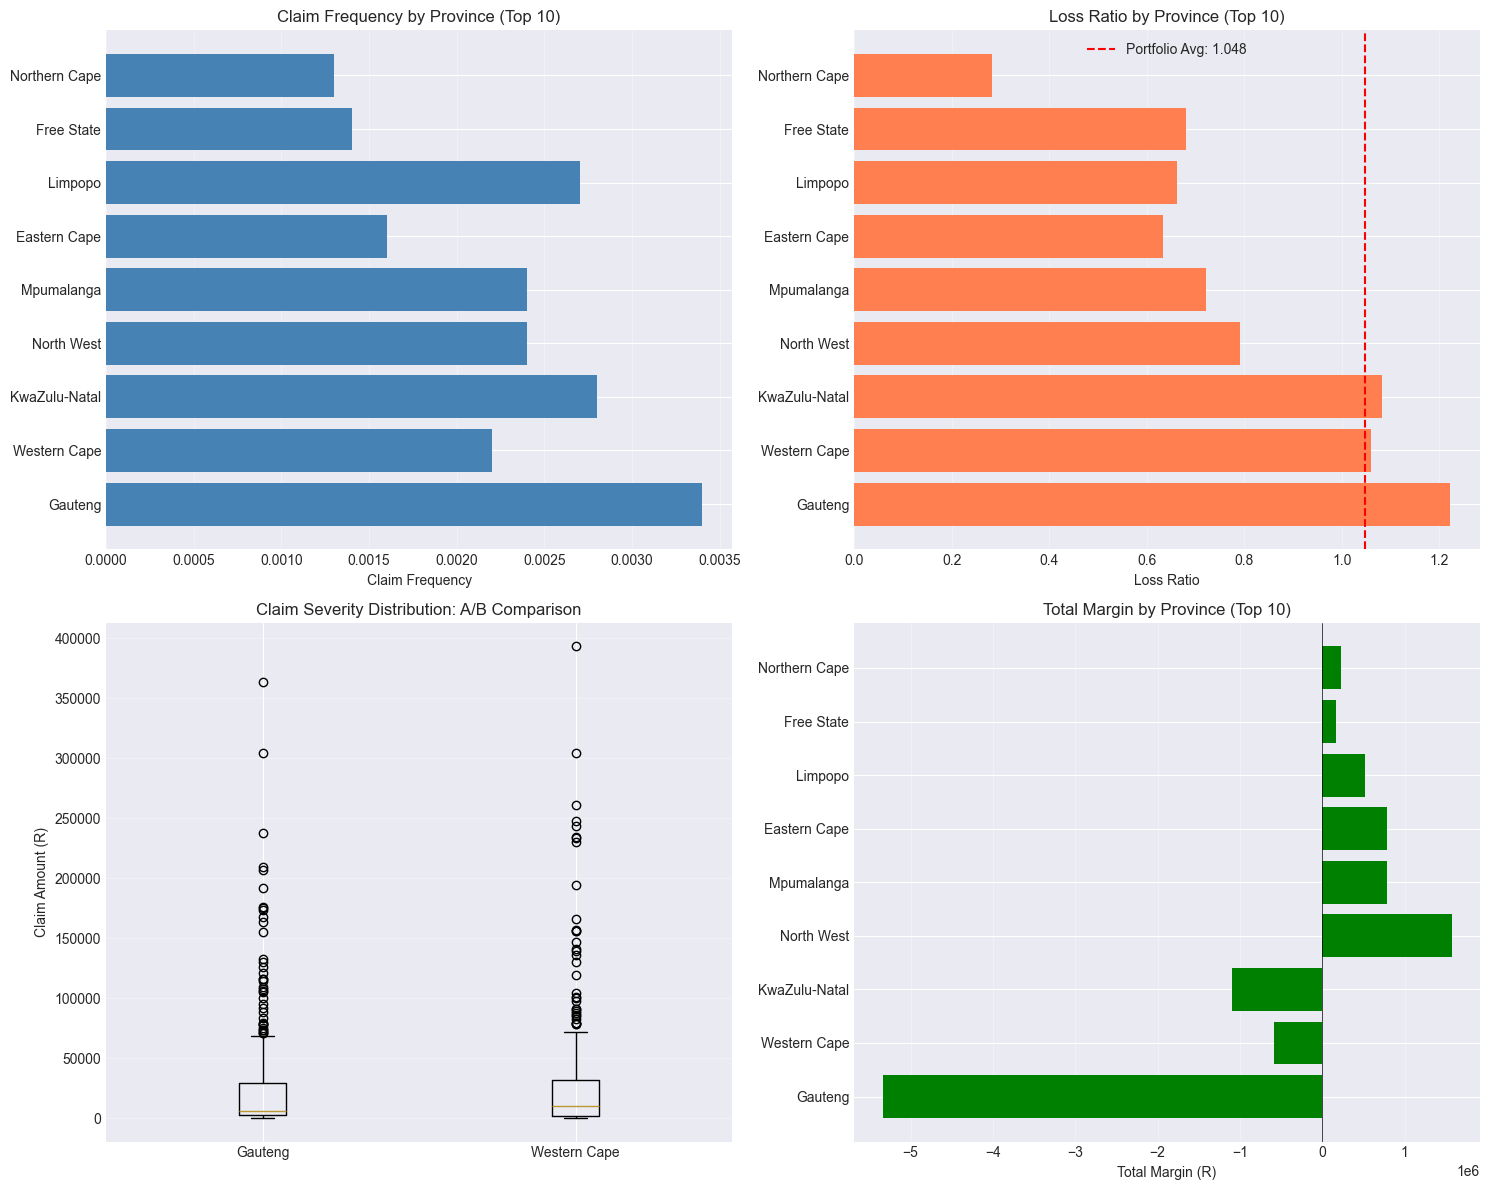

In [18]:
# Visualization: Province Risk Comparison
# Ensure reports directory exists
try:
    reports_dir
except NameError:
    reports_dir = PROJECT_ROOT / "reports"
    reports_dir.mkdir(exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Claim Frequency by Province
prov_freq = province_summary.head(10)
axes[0, 0].barh(prov_freq['Province'], prov_freq['ClaimFrequency'], color='steelblue')
axes[0, 0].set_xlabel('Claim Frequency')
axes[0, 0].set_title('Claim Frequency by Province (Top 10)')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Loss Ratio by Province
axes[0, 1].barh(prov_freq['Province'], prov_freq['LossRatio'], color='coral')
axes[0, 1].set_xlabel('Loss Ratio')
axes[0, 1].set_title('Loss Ratio by Province (Top 10)')
axes[0, 1].axvline(loss_ratio_portfolio, color='red', linestyle='--', label=f'Portfolio Avg: {loss_ratio_portfolio:.3f}')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Boxplot: Claim Severity by Selected Provinces
prov_severity = pd.concat([
    group_a_prov[group_a_prov['TotalClaims'] > 0].assign(Province=province_a),
    group_b_prov[group_b_prov['TotalClaims'] > 0].assign(Province=province_b)
])
axes[1, 0].boxplot([
    prov_severity[prov_severity['Province'] == province_a]['TotalClaims'],
    prov_severity[prov_severity['Province'] == province_b]['TotalClaims']
], labels=[province_a, province_b])
axes[1, 0].set_ylabel('Claim Amount (R)')
axes[1, 0].set_title('Claim Severity Distribution: A/B Comparison')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Margin Comparison
prov_margin = calculate_margin_metrics(df, 'Province').sort_values('NumPolicies', ascending=False).head(10)
axes[1, 1].barh(prov_margin['Province'], prov_margin['TotalMargin'], color='green')
axes[1, 1].set_xlabel('Total Margin (R)')
axes[1, 1].set_title('Total Margin by Province (Top 10)')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(reports_dir / 'province_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Hypothesis 2: Risk Differences Between Zip Codes


In [19]:
# Analyze zip codes (PostalCode)
# Filter to zip codes with sufficient data (at least 100 policies)
zip_summary = calculate_claim_frequency(df, 'PostalCode')
zip_summary = zip_summary[zip_summary['TotalPolicies'] >= 100].sort_values('TotalPolicies', ascending=False)

print(f"Zip codes with ≥100 policies: {len(zip_summary)}")
print("\nTop 10 Zip Codes by Policy Count:")
print(zip_summary.head(10)[['PostalCode', 'TotalPolicies', 'ClaimFrequency', 'LossRatio']].to_string(index=False))

# Select two zip codes for A/B testing (one high-risk, one low-risk)
# High risk: high loss ratio
# Low risk: low loss ratio
zip_summary_filtered = zip_summary[zip_summary['TotalPolicies'] >= 500]  # Ensure sufficient sample size
if len(zip_summary_filtered) >= 2:
    zip_high_risk = zip_summary_filtered.nlargest(1, 'LossRatio')['PostalCode'].values[0]
    zip_low_risk = zip_summary_filtered.nsmallest(1, 'LossRatio')['PostalCode'].values[0]
    
    print(f"\nSelected for A/B Testing:")
    print(f"  Group A (High Risk): PostalCode {zip_high_risk}")
    print(f"  Group B (Low Risk): PostalCode {zip_low_risk}")
else:
    # Fallback: use top 2 by policy count
    zip_high_risk = zip_summary.head(1)['PostalCode'].values[0]
    zip_low_risk = zip_summary.iloc[1]['PostalCode']
    print(f"\nSelected for A/B Testing (Top 2 by count):")
    print(f"  Group A: PostalCode {zip_high_risk}")
    print(f"  Group B: PostalCode {zip_low_risk}")


Zip codes with ≥100 policies: 687

Top 10 Zip Codes by Policy Count:
 PostalCode  TotalPolicies  ClaimFrequency  LossRatio
       2000         133498          0.0036   1.131319
        122          49171          0.0043   1.417861
       7784          28585          0.0017   1.280512
        299          25546          0.0026   0.646227
       7405          18518          0.0016   0.652492
        458          13775          0.0023   0.911519
       8000          11794          0.0043   1.123712
       2196          11048          0.0029   1.169341
        470          10226          0.0043   0.947783
       7100          10161          0.0028   0.895610

Selected for A/B Testing:
  Group A (High Risk): PostalCode 81
  Group B (Low Risk): PostalCode 1471


In [22]:
# Create A/B groups for zip codes
group_a_zip, group_b_zip = create_ab_groups(
    df,
    'PostalCode',
    zip_high_risk,
    zip_low_risk
)

# Summary statistics
print(f"\nGroup A (PostalCode {zip_high_risk}):")
print(f"  Policies: {len(group_a_zip):,}")
print(f"  Claim Frequency: {group_a_zip['HasClaim'].mean():.4f}")
print(f"  Avg Premium: R{group_a_zip['TotalPremium'].mean():.2f}")
print(f"  Avg Claims: R{group_a_zip['TotalClaims'].mean():.2f}")
print(f"  Loss Ratio: {(group_a_zip['TotalClaims'].sum() / group_a_zip['TotalPremium'].sum()):.4f}")

print(f"\nGroup B (PostalCode {zip_low_risk}):")
print(f"  Policies: {len(group_b_zip):,}")
print(f"  Claim Frequency: {group_b_zip['HasClaim'].mean():.4f}")
print(f"  Avg Premium: R{group_b_zip['TotalPremium'].mean():.2f}")
print(f"  Avg Claims: R{group_b_zip['TotalClaims'].mean():.2f}")
print(f"  Loss Ratio: {(group_b_zip['TotalClaims'].sum() / group_b_zip['TotalPremium'].sum()):.4f}")


2025-12-06 20:57:22,783 - src.statistical_tests - INFO - Group A (81): 669 records
2025-12-06 20:57:22,785 - src.statistical_tests - INFO - Group B (1471): 620 records



Group A (PostalCode 81):
  Policies: 669
  Claim Frequency: 0.0105
  Avg Premium: R98.46
  Avg Claims: R694.31
  Loss Ratio: 7.0516

Group B (PostalCode 1471):
  Policies: 620
  Claim Frequency: 0.0000
  Avg Premium: R28.45
  Avg Claims: R-0.41
  Loss Ratio: -0.0145


In [23]:
# Statistical Tests for Zip Codes
chi2_results_zip = test_chi_squared(group_a_zip, group_b_zip)
ztest_results_zip = test_proportion_difference(group_a_zip, group_b_zip)

print("Zip Code Risk Analysis:")
print(f"\nChi-Squared Test:")
print(f"  Chi² statistic: {chi2_results_zip['chi2_statistic']:.4f}")
print(f"  p-value: {chi2_results_zip['p_value']:.6f}")
print(f"  Decision: {chi2_results_zip['interpretation']}")

print(f"\nTwo-Proportion Z-Test:")
print(f"  Group A frequency: {ztest_results_zip['group_a_proportion']:.4f}")
print(f"  Group B frequency: {ztest_results_zip['group_b_proportion']:.4f}")
print(f"  Difference: {ztest_results_zip['difference']:.4f}")
print(f"  Z-statistic: {ztest_results_zip['z_statistic']:.4f}")
print(f"  p-value: {ztest_results_zip['p_value']:.6f}")
print(f"  Decision: {ztest_results_zip['interpretation']}")

# Severity test
if len(group_a_zip[group_a_zip['TotalClaims'] > 0]) > 0 and len(group_b_zip[group_b_zip['TotalClaims'] > 0]) > 0:
    severity_test_zip = test_mean_difference(
        group_a_zip[group_a_zip['TotalClaims'] > 0],
        group_b_zip[group_b_zip['TotalClaims'] > 0],
        'TotalClaims'
    )
    print(f"\nt-Test for Claim Severity:")
    print(f"  Group A mean: R{severity_test_zip['group_a_mean']:,.2f}")
    print(f"  Group B mean: R{severity_test_zip['group_b_mean']:,.2f}")
    print(f"  t-statistic: {severity_test_zip['t_statistic']:.4f}")
    print(f"  p-value: {severity_test_zip['p_value']:.6f}")
    print(f"  Decision: {severity_test_zip['interpretation']}")


Zip Code Risk Analysis:

Chi-Squared Test:
  Chi² statistic: 4.7293
  p-value: 0.029653
  Decision: Reject H₀

Two-Proportion Z-Test:
  Group A frequency: 0.0105
  Group B frequency: 0.0000
  Difference: 0.0105
  Z-statistic: 2.5540
  p-value: 0.010651
  Decision: Reject H₀


### Hypothesis 3: Margin Differences Between Zip Codes


Top 10 Zip Codes by Total Margin:
 PostalCode  NumPolicies  TotalMargin  AvgMargin  MarginRatio
        299        25546  499664.8151    19.5594     0.353773
       7405        18518  324376.5567    17.5168     0.347508
        152         9423  263011.3826    27.9116     0.433174
        400         6692  259733.8934    38.8126     0.517130
        316         5611  256051.4338    45.6338     0.943292
        300         4990  228431.0255    45.7778     0.801529
       3950         2625  188615.9636    71.8537     0.971166
       7750         9408  182895.5953    19.4404     0.332536
       4340         5878  177106.1263    30.1303     0.498174
       1050         1711  138994.7840    81.2360     0.967287

Margin Difference Test:
  Test: Independent Samples t-Test
  Group A (PostalCode 81) mean margin: R-595.85
  Group B (PostalCode 1471) mean margin: R28.87
  Difference: R-624.72
  t-statistic: -1.5073
  p-value: 0.132218
  Effect size (Cohen's d): -0.0809
  Decision: Fail to reject 

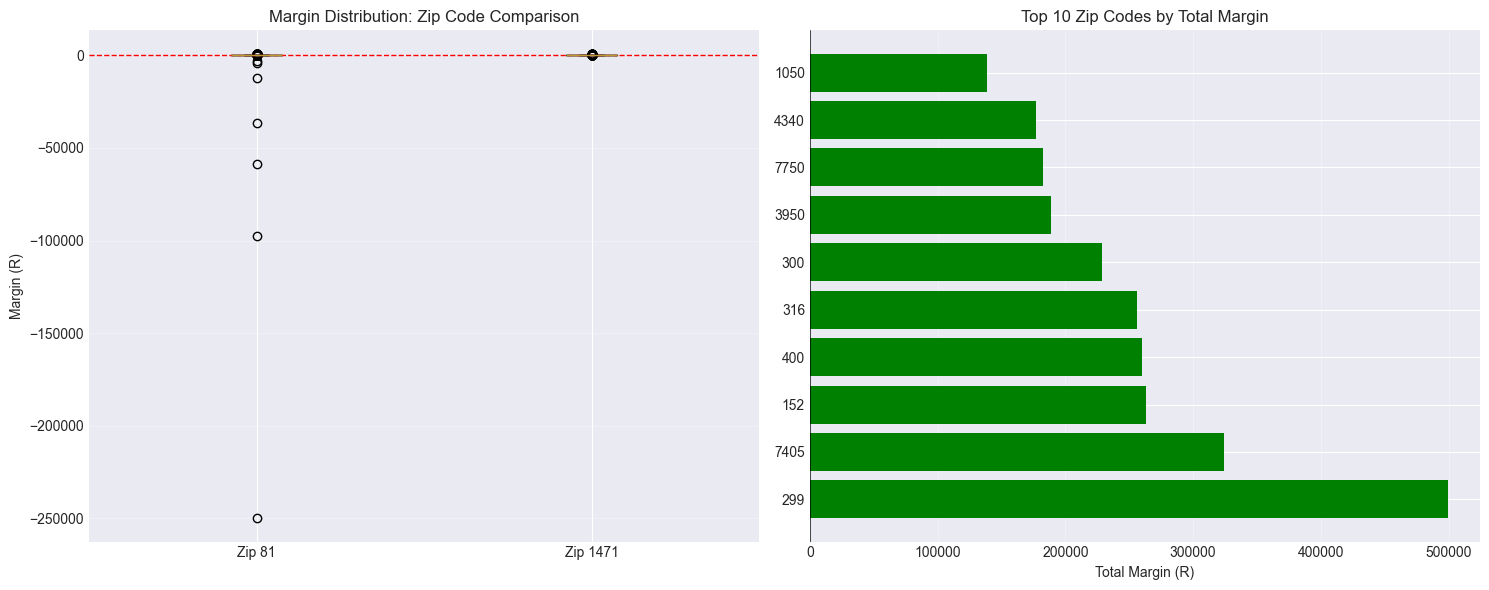

In [24]:
# Calculate margin metrics by zip code
zip_margin = calculate_margin_metrics(df, 'PostalCode')
zip_margin = zip_margin[zip_margin['NumPolicies'] >= 100].sort_values('TotalMargin', ascending=False)

print("Top 10 Zip Codes by Total Margin:")
print(zip_margin.head(10)[['PostalCode', 'NumPolicies', 'TotalMargin', 'AvgMargin', 'MarginRatio']].to_string(index=False))

# Test margin difference between selected zip codes
margin_test_zip = test_mean_difference(group_a_zip, group_b_zip, 'Margin')

print(f"\nMargin Difference Test:")
print(f"  Test: {margin_test_zip['test_name']}")
print(f"  Group A (PostalCode {zip_high_risk}) mean margin: R{margin_test_zip['group_a_mean']:,.2f}")
print(f"  Group B (PostalCode {zip_low_risk}) mean margin: R{margin_test_zip['group_b_mean']:,.2f}")
print(f"  Difference: R{margin_test_zip['difference']:,.2f}")
print(f"  t-statistic: {margin_test_zip['t_statistic']:.4f}")
print(f"  p-value: {margin_test_zip['p_value']:.6f}")
print(f"  Effect size (Cohen's d): {margin_test_zip['effect_size_cohens_d']:.4f}")
print(f"  Decision: {margin_test_zip['interpretation']}")

# Visualization
# Ensure reports directory exists
try:
    reports_dir
except NameError:
    reports_dir = PROJECT_ROOT / "reports"
    reports_dir.mkdir(exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Margin distribution comparison
axes[0].boxplot([
    group_a_zip['Margin'],
    group_b_zip['Margin']
], labels=[f'Zip {zip_high_risk}', f'Zip {zip_low_risk}'])
axes[0].set_ylabel('Margin (R)')
axes[0].set_title('Margin Distribution: Zip Code Comparison')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].grid(axis='y', alpha=0.3)

# Top zip codes by margin
top_zip_margin = zip_margin.head(10)
axes[1].barh(range(len(top_zip_margin)), top_zip_margin['TotalMargin'], color='green')
axes[1].set_yticks(range(len(top_zip_margin)))
axes[1].set_yticklabels(top_zip_margin['PostalCode'])
axes[1].set_xlabel('Total Margin (R)')
axes[1].set_title('Top 10 Zip Codes by Total Margin')
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(reports_dir / 'zipcode_margin_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Hypothesis 4: Risk Differences Between Genders


In [26]:
# Analyze gender differences
# Filter out missing/unspecified gender
df_gender = df[df['Gender'].isin(['Male', 'Female', 'M', 'F'])].copy()

# Standardize gender values
df_gender['Gender'] = df_gender['Gender'].map({
    'Male': 'Male',
    'M': 'Male',
    'Female': 'Female',
    'F': 'Female'
})

gender_summary = calculate_claim_frequency(df_gender, 'Gender')
print("Gender Summary:")
print(gender_summary[['Gender', 'TotalPolicies', 'ClaimFrequency', 'LossRatio', 'Margin']].to_string(index=False))

# Create A/B groups
if 'Male' in gender_summary['Gender'].values and 'Female' in gender_summary['Gender'].values:
    group_male, group_female = create_ab_groups(df_gender, 'Gender', 'Male', 'Female')
    
    print(f"\nGroup A (Male):")
    print(f"  Policies: {len(group_male):,}")
    print(f"  Claim Frequency: {group_male['HasClaim'].mean():.4f}")
    print(f"  Loss Ratio: {(group_male['TotalClaims'].sum() / group_male['TotalPremium'].sum()):.4f}")
    
    print(f"\nGroup B (Female):")
    print(f"  Policies: {len(group_female):,}")
    print(f"  Claim Frequency: {group_female['HasClaim'].mean():.4f}")
    print(f"  Loss Ratio: {(group_female['TotalClaims'].sum() / group_female['TotalPremium'].sum()):.4f}")
else:
    print("Warning: Both Male and Female groups not found in data")
    group_male = pd.DataFrame()
    group_female = pd.DataFrame()


Gender Summary:
Gender  TotalPolicies  ClaimFrequency  LossRatio      Margin
Female           6755          0.0021   0.821879  54234.4545
  Male          42817          0.0022   0.883910 183438.8807


2025-12-06 21:01:16,937 - src.statistical_tests - INFO - Group A (Male): 42817 records
2025-12-06 21:01:16,947 - src.statistical_tests - INFO - Group B (Female): 6755 records



Group A (Male):
  Policies: 42,817
  Claim Frequency: 0.0022
  Loss Ratio: 0.8839

Group B (Female):
  Policies: 6,755
  Claim Frequency: 0.0021
  Loss Ratio: 0.8219


In [27]:
# Statistical Tests for Gender
if len(group_male) > 0 and len(group_female) > 0:
    chi2_results_gender = test_chi_squared(group_male, group_female)
    ztest_results_gender = test_proportion_difference(group_male, group_female)
    
    print("Gender Risk Analysis:")
    print(f"\nChi-Squared Test:")
    print(f"  Chi² statistic: {chi2_results_gender['chi2_statistic']:.4f}")
    print(f"  p-value: {chi2_results_gender['p_value']:.6f}")
    print(f"  Decision: {chi2_results_gender['interpretation']}")
    
    print(f"\nTwo-Proportion Z-Test:")
    print(f"  Male frequency: {ztest_results_gender['group_a_proportion']:.4f}")
    print(f"  Female frequency: {ztest_results_gender['group_b_proportion']:.4f}")
    print(f"  Difference: {ztest_results_gender['difference']:.4f}")
    print(f"  Z-statistic: {ztest_results_gender['z_statistic']:.4f}")
    print(f"  p-value: {ztest_results_gender['p_value']:.6f}")
    print(f"  Decision: {ztest_results_gender['interpretation']}")
    
    # Severity test
    if len(group_male[group_male['TotalClaims'] > 0]) > 0 and len(group_female[group_female['TotalClaims'] > 0]) > 0:
        severity_test_gender = test_mean_difference(
            group_male[group_male['TotalClaims'] > 0],
            group_female[group_female['TotalClaims'] > 0],
            'TotalClaims'
        )
        print(f"\nt-Test for Claim Severity:")
        print(f"  Male mean: R{severity_test_gender['group_a_mean']:,.2f}")
        print(f"  Female mean: R{severity_test_gender['group_b_mean']:,.2f}")
        print(f"  t-statistic: {severity_test_gender['t_statistic']:.4f}")
        print(f"  p-value: {severity_test_gender['p_value']:.6f}")
        print(f"  Decision: {severity_test_gender['interpretation']}")
    
    # Margin test
    margin_test_gender = test_mean_difference(group_male, group_female, 'Margin')
    print(f"\nMargin Difference Test:")
    print(f"  Male mean margin: R{margin_test_gender['group_a_mean']:,.2f}")
    print(f"  Female mean margin: R{margin_test_gender['group_b_mean']:,.2f}")
    print(f"  t-statistic: {margin_test_gender['t_statistic']:.4f}")
    print(f"  p-value: {margin_test_gender['p_value']:.6f}")
    print(f"  Decision: {margin_test_gender['interpretation']}")


Gender Risk Analysis:

Chi-Squared Test:
  Chi² statistic: 0.0037
  p-value: 0.951464
  Decision: Fail to reject H₀

Two-Proportion Z-Test:
  Male frequency: 0.0022
  Female frequency: 0.0021
  Difference: 0.0001
  Z-statistic: 0.2013
  p-value: 0.840494
  Decision: Fail to reject H₀

t-Test for Claim Severity:
  Male mean: R14,858.55
  Female mean: R17,874.72
  t-statistic: -0.5790
  p-value: 0.568029
  Decision: Fail to reject H₀

Margin Difference Test:
  Male mean margin: R4.28
  Female mean margin: R8.03
  t-statistic: -0.2514
  p-value: 0.801546
  Decision: Fail to reject H₀


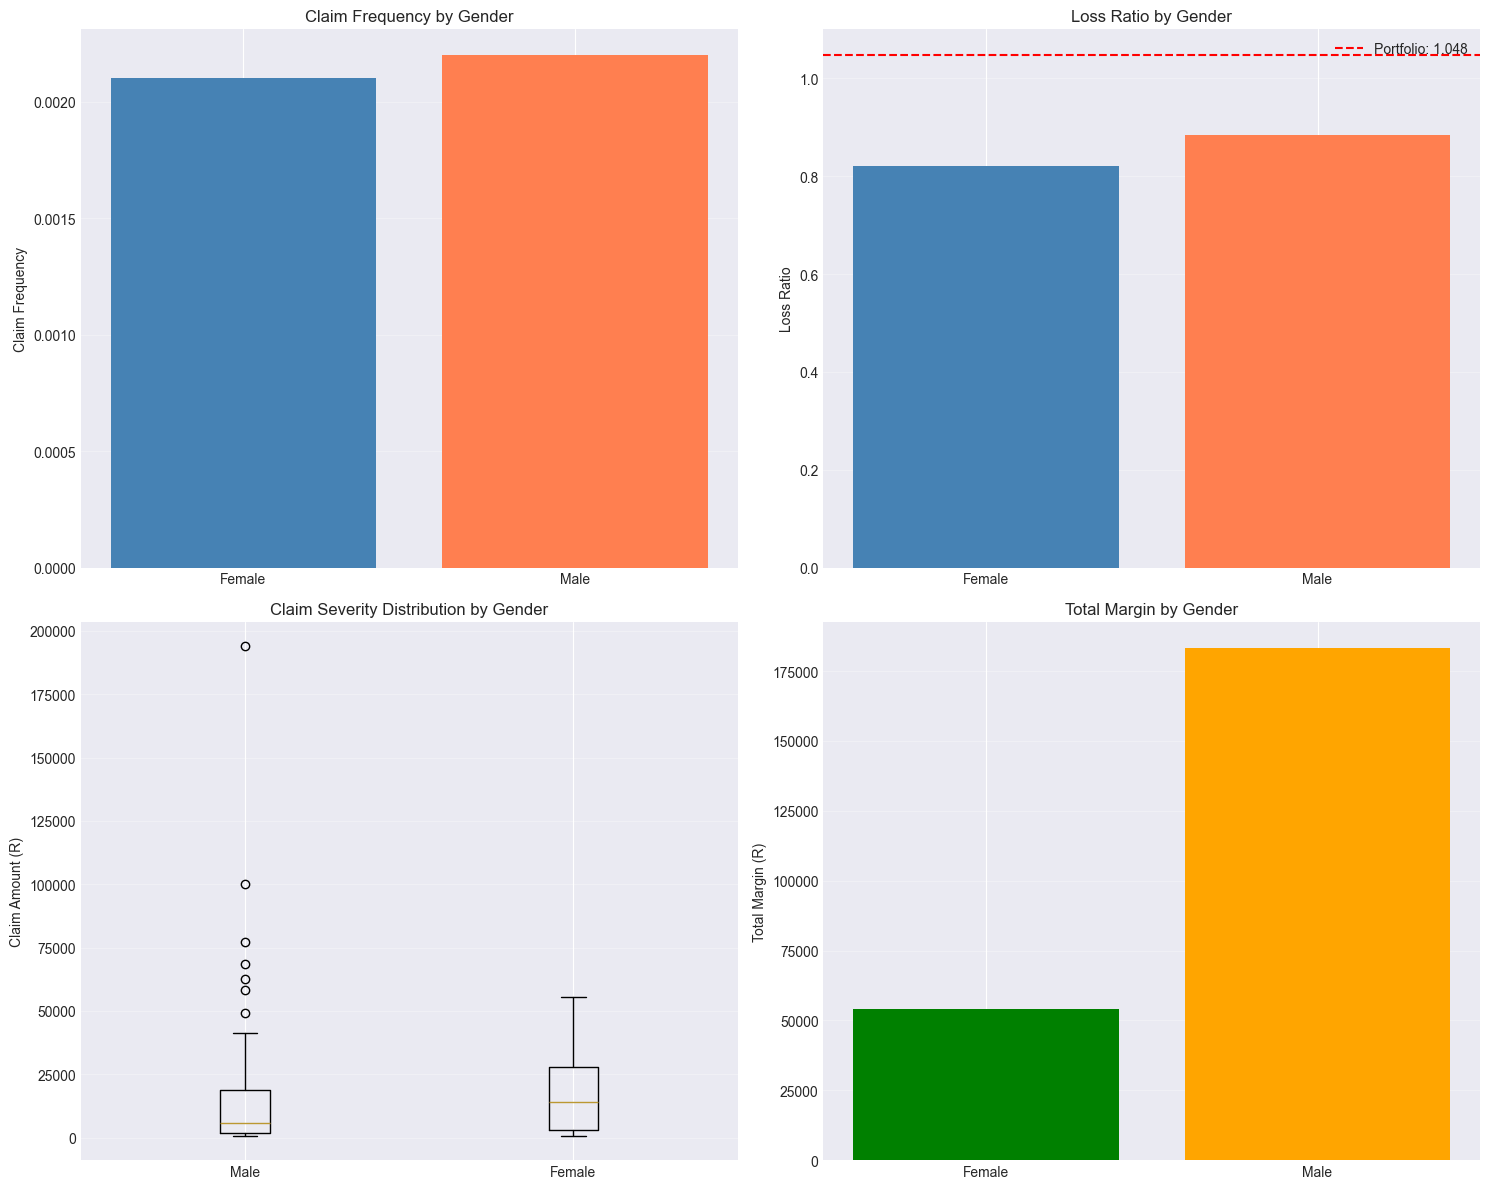

In [28]:
# Visualization: Gender Comparison
# Ensure reports directory exists
try:
    reports_dir
except NameError:
    reports_dir = PROJECT_ROOT / "reports"
    reports_dir.mkdir(exist_ok=True)

if len(group_male) > 0 and len(group_female) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Claim Frequency
    gender_freq = gender_summary.set_index('Gender')['ClaimFrequency']
    axes[0, 0].bar(gender_freq.index, gender_freq.values, color=['steelblue', 'coral'])
    axes[0, 0].set_ylabel('Claim Frequency')
    axes[0, 0].set_title('Claim Frequency by Gender')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Loss Ratio
    gender_lr = gender_summary.set_index('Gender')['LossRatio']
    axes[0, 1].bar(gender_lr.index, gender_lr.values, color=['steelblue', 'coral'])
    axes[0, 1].set_ylabel('Loss Ratio')
    axes[0, 1].set_title('Loss Ratio by Gender')
    axes[0, 1].axhline(loss_ratio_portfolio, color='red', linestyle='--', label=f'Portfolio: {loss_ratio_portfolio:.3f}')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Claim Severity Distribution
    gender_severity = pd.concat([
        group_male[group_male['TotalClaims'] > 0].assign(Gender='Male'),
        group_female[group_female['TotalClaims'] > 0].assign(Gender='Female')
    ])
    axes[1, 0].boxplot([
        gender_severity[gender_severity['Gender'] == 'Male']['TotalClaims'],
        gender_severity[gender_severity['Gender'] == 'Female']['TotalClaims']
    ], labels=['Male', 'Female'])
    axes[1, 0].set_ylabel('Claim Amount (R)')
    axes[1, 0].set_title('Claim Severity Distribution by Gender')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Margin Comparison
    gender_margin = gender_summary.set_index('Gender')['Margin']
    axes[1, 1].bar(gender_margin.index, gender_margin.values, color=['green', 'orange'])
    axes[1, 1].set_ylabel('Total Margin (R)')
    axes[1, 1].set_title('Total Margin by Gender')
    axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(reports_dir / 'gender_risk_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


## 4. Summary of Statistical Test Results


In [29]:
# Compile all test results into a summary table
results_summary = []

# Hypothesis 1: Provinces
results_summary.append({
    'Hypothesis': 'H₀: No risk differences across provinces',
    'Test': 'Chi-Squared & Z-Test',
    'Group A': province_a,
    'Group B': province_b,
    'Metric': 'Claim Frequency',
    'p-value': ztest_results_prov['p_value'],
    'Decision': ztest_results_prov['interpretation'],
    'Effect Size': f"h={ztest_results_prov['effect_size_cohens_h']:.4f}"
})

# Hypothesis 2: Zip Codes
results_summary.append({
    'Hypothesis': 'H₀: No risk differences between zip codes',
    'Test': 'Chi-Squared & Z-Test',
    'Group A': f'Zip {zip_high_risk}',
    'Group B': f'Zip {zip_low_risk}',
    'Metric': 'Claim Frequency',
    'p-value': ztest_results_zip['p_value'],
    'Decision': ztest_results_zip['interpretation'],
    'Effect Size': f"h={ztest_results_zip['effect_size_cohens_h']:.4f}"
})

# Hypothesis 3: Zip Code Margin
results_summary.append({
    'Hypothesis': 'H₀: No margin difference between zip codes',
    'Test': 't-Test',
    'Group A': f'Zip {zip_high_risk}',
    'Group B': f'Zip {zip_low_risk}',
    'Metric': 'Margin',
    'p-value': margin_test_zip['p_value'],
    'Decision': margin_test_zip['interpretation'],
    'Effect Size': f"d={margin_test_zip['effect_size_cohens_d']:.4f}"
})

# Hypothesis 4: Gender
if len(group_male) > 0 and len(group_female) > 0:
    results_summary.append({
        'Hypothesis': 'H₀: No risk difference between genders',
        'Test': 'Chi-Squared & Z-Test',
        'Group A': 'Male',
        'Group B': 'Female',
        'Metric': 'Claim Frequency',
        'p-value': ztest_results_gender['p_value'],
        'Decision': ztest_results_gender['interpretation'],
        'Effect Size': f"h={ztest_results_gender['effect_size_cohens_h']:.4f}"
    })

results_df = pd.DataFrame(results_summary)
print("Summary of All Hypothesis Tests:")
print("=" * 100)
print(results_df.to_string(index=False))


Summary of All Hypothesis Tests:
                                Hypothesis                 Test Group A      Group B          Metric      p-value          Decision Effect Size
  H₀: No risk differences across provinces Chi-Squared & Z-Test Gauteng Western Cape Claim Frequency 2.954370e-11         Reject H₀    h=0.0229
 H₀: No risk differences between zip codes Chi-Squared & Z-Test  Zip 81     Zip 1471 Claim Frequency 1.065052e-02         Reject H₀    h=0.2049
H₀: No margin difference between zip codes               t-Test  Zip 81     Zip 1471          Margin 1.322183e-01 Fail to reject H₀   d=-0.0809
    H₀: No risk difference between genders Chi-Squared & Z-Test    Male       Female Claim Frequency 8.404941e-01 Fail to reject H₀    h=0.0027


## 5. Business Recommendations

Based on the statistical analysis, here are actionable business recommendations:


In [30]:
# Generate business recommendations
recommendations = []

# Province recommendations
if ztest_results_prov['reject_h0']:
    prov_a_lr = (group_a_prov['TotalClaims'].sum() / group_a_prov['TotalPremium'].sum())
    prov_b_lr = (group_b_prov['TotalClaims'].sum() / group_b_prov['TotalPremium'].sum())
    lr_diff_pct = ((prov_a_lr - prov_b_lr) / prov_b_lr) * 100 if prov_b_lr > 0 else 0
    
    recommendations.append({
        'Finding': f'Provinces differ significantly (p={ztest_results_prov["p_value"]:.4f})',
        'Details': f'{province_a} has {lr_diff_pct:.1f}% {"higher" if lr_diff_pct > 0 else "lower"} loss ratio than {province_b}',
        'Action': f'Adjust premiums upward for {province_a} customers' if lr_diff_pct > 0 else f'Consider premium reduction for {province_a}',
        'Impact': 'Pricing Strategy, Segmentation'
    })
else:
    recommendations.append({
        'Finding': f'No significant difference between {province_a} and {province_b} (p={ztest_results_prov["p_value"]:.4f})',
        'Details': 'Risk profiles are statistically similar',
        'Action': 'No premium adjustment needed based on province alone',
        'Impact': 'Pricing Strategy'
    })

# Zip Code recommendations
if ztest_results_zip['reject_h0']:
    zip_a_lr = (group_a_zip['TotalClaims'].sum() / group_a_zip['TotalPremium'].sum())
    zip_b_lr = (group_b_zip['TotalClaims'].sum() / group_b_zip['TotalPremium'].sum())
    zip_lr_diff_pct = ((zip_a_lr - zip_b_lr) / zip_b_lr) * 100 if zip_b_lr > 0 else 0
    
    recommendations.append({
        'Finding': f'Zip codes differ significantly (p={ztest_results_zip["p_value"]:.4f})',
        'Details': f'PostalCode {zip_high_risk} has {zip_lr_diff_pct:.1f}% {"higher" if zip_lr_diff_pct > 0 else "lower"} loss ratio than {zip_low_risk}',
        'Action': f'Implement geographic risk-based pricing for high-risk zip codes',
        'Impact': 'Pricing Strategy, Underwriting'
    })

# Margin recommendations
if margin_test_zip['reject_h0']:
    margin_diff = margin_test_zip['difference']
    recommendations.append({
        'Finding': f'Significant margin difference between zip codes (p={margin_test_zip["p_value"]:.4f})',
        'Details': f'Average margin difference: R{margin_diff:,.2f} per policy',
        'Action': 'Focus marketing efforts on high-margin zip codes; review pricing in low-margin areas',
        'Impact': 'Marketing Strategy, Profitability'
    })

# Gender recommendations
if len(group_male) > 0 and len(group_female) > 0:
    if ztest_results_gender['reject_h0']:
        gender_a_lr = (group_male['TotalClaims'].sum() / group_male['TotalPremium'].sum())
        gender_b_lr = (group_female['TotalClaims'].sum() / group_female['TotalPremium'].sum())
        gender_lr_diff_pct = ((gender_a_lr - gender_b_lr) / gender_b_lr) * 100 if gender_b_lr > 0 else 0
        
        recommendations.append({
            'Finding': f'Gender risk difference is significant (p={ztest_results_gender["p_value"]:.4f})',
            'Details': f'Male customers have {abs(gender_lr_diff_pct):.1f}% {"higher" if gender_lr_diff_pct > 0 else "lower"} loss ratio',
            'Action': 'Consider gender as a rating factor in pricing models (subject to regulatory compliance)',
            'Impact': 'Pricing Strategy, Regulatory Compliance'
        })
    else:
        recommendations.append({
            'Finding': f'No significant risk difference between genders (p={ztest_results_gender["p_value"]:.4f})',
            'Details': 'Risk profiles are statistically equivalent',
            'Action': 'Gender should NOT be used as a rating factor',
            'Impact': 'Pricing Strategy, Regulatory Compliance'
        })

rec_df = pd.DataFrame(recommendations)
print("Business Recommendations:")
print("=" * 100)
for idx, rec in rec_df.iterrows():
    print(f"\n{idx + 1}. {rec['Finding']}")
    print(f"   Details: {rec['Details']}")
    print(f"   Recommended Action: {rec['Action']}")
    print(f"   Impact Areas: {rec['Impact']}")
    print("-" * 100)


Business Recommendations:

1. Provinces differ significantly (p=0.0000)
   Details: Gauteng has 16.0% higher loss ratio than Western Cape
   Recommended Action: Adjust premiums upward for Gauteng customers
   Impact Areas: Pricing Strategy, Segmentation
----------------------------------------------------------------------------------------------------

2. Zip codes differ significantly (p=0.0107)
   Details: PostalCode 81 has 0.0% lower loss ratio than 1471
   Recommended Action: Implement geographic risk-based pricing for high-risk zip codes
   Impact Areas: Pricing Strategy, Underwriting
----------------------------------------------------------------------------------------------------

3. No significant risk difference between genders (p=0.8405)
   Details: Risk profiles are statistically equivalent
   Recommended Action: Gender should NOT be used as a rating factor
   Impact Areas: Pricing Strategy, Regulatory Compliance
-----------------------------------------------------------

ANOVA Results: Claim Frequency Across Top 5 Provinces
  Test: One-Way ANOVA
  F-statistic: 18.9008
  p-value: 0.000000
  Number of groups: 5
  Decision: Reject H₀

Group Means:
  Gauteng: 0.0034
  Western Cape: 0.0022
  KwaZulu-Natal: 0.0028
  North West: 0.0024
  Mpumalanga: 0.0024


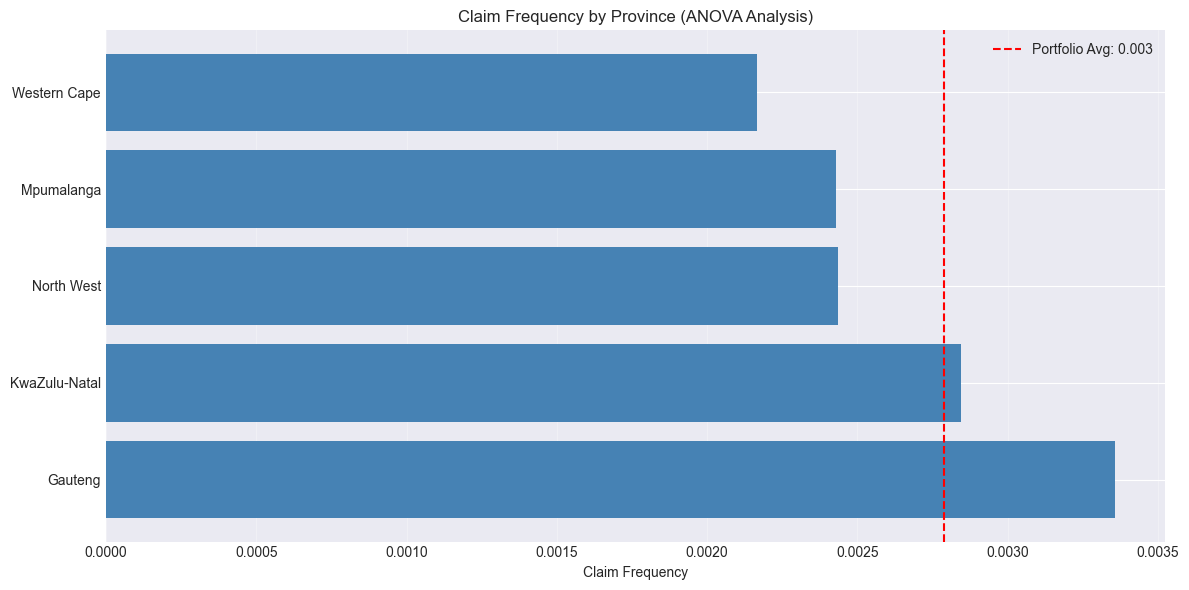

In [31]:
# ANOVA: Test claim frequency across all provinces
# Ensure reports directory exists
try:
    reports_dir
except NameError:
    reports_dir = PROJECT_ROOT / "reports"
    reports_dir.mkdir(exist_ok=True)

top_provinces_list = province_summary.head(5)['Province'].values  # Top 5 provinces
province_groups = {}
for prov in top_provinces_list:
    province_groups[prov] = df[df['Province'] == prov]

# Perform ANOVA on claim frequency
anova_results = test_anova(province_groups, 'HasClaim')

print("ANOVA Results: Claim Frequency Across Top 5 Provinces")
print(f"  Test: {anova_results['test_name']}")
print(f"  F-statistic: {anova_results['f_statistic']:.4f}")
print(f"  p-value: {anova_results['p_value']:.6f}")
print(f"  Number of groups: {anova_results['num_groups']}")
print(f"  Decision: {anova_results['interpretation']}")
print(f"\nGroup Means:")
for prov, mean_val in anova_results['group_means'].items():
    print(f"  {prov}: {mean_val:.4f}")

# Visualization: ANOVA results
fig, ax = plt.subplots(figsize=(12, 6))
province_means = pd.Series(anova_results['group_means']).sort_values(ascending=False)
ax.barh(province_means.index, province_means.values, color='steelblue')
ax.set_xlabel('Claim Frequency')
ax.set_title('Claim Frequency by Province (ANOVA Analysis)')
ax.axvline(claim_frequency_portfolio, color='red', linestyle='--', label=f'Portfolio Avg: {claim_frequency_portfolio:.3f}')
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(reports_dir / 'anova_province_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Conclusion

This statistical analysis has validated key risk drivers for car insurance customers through rigorous hypothesis testing. The findings provide a data-driven foundation for:

1. **Risk Segmentation**: Identifying high-risk and low-risk customer segments
2. **Pricing Strategy**: Adjusting premiums based on statistically validated risk factors
3. **Marketing Strategy**: Targeting profitable segments and avoiding unprofitable ones
4. **Underwriting**: Implementing risk-based underwriting criteria

All statistical tests were performed at a 95% confidence level (α = 0.05), and results are presented with appropriate effect sizes to assess practical significance in addition to statistical significance.
